In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, make_scorer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import chi2, t, f, norm
from scipy.special import binom

sns.set(font_scale=1)

import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import roc_curve, auc

def plot_roc_auc(ps, ys, labels):
    plt.figure(figsize=(12, 8), dpi=100)
    
    lw = 2
    for p, y, label in zip(ps, ys, labels):
        fpr, tpr, _ = roc_curve(y, p)
        plt.step(fpr, tpr, alpha=1.,  label=label + ', ROC-AUC={}'.format(auc(fpr, tpr)))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return 

Статья полу-оригинал: https://arxiv.org/pdf/1811.12808.pdf

# 1. Problem statement

Во-первых, сделаем игрушечную проблему для которой мы можем посчитать идеальный скор с помощью оптимального байесовского классификатора.

In [5]:
from sklearn.datasets import make_spd_matrix
class ClassificationProblem:
    def __init__(self, p=0.9, dim=100, diff_coef=1., random_seed=1337):
        self._p = p
        self._dim = dim
        distrs = [stats.norm()]
        np.random.seed(random_seed)
        self._class_one_distr = np.random.choice(distrs, size=dim, replace=True)
        m = make_spd_matrix(dim)
        m = m.dot(m) + np.eye(dim)
        self._class_one_shift = np.random.randn(dim) * diff_coef
        self._class_one_mixing_matrix = m
        self._class_one_inv_mixing_matrix = np.linalg.inv(self._class_one_mixing_matrix)
        
        self._class_two_distr = self._class_one_distr
        m = make_spd_matrix(dim)
        m = m.dot(m)
        self._class_two_shift = np.random.randn(dim) * diff_coef
        self._class_two_mixing_matrix = self._class_one_mixing_matrix + np.eye(dim)
        self._class_two_inv_mixing_matrix = np.linalg.inv(self._class_two_mixing_matrix)
        np.random.seed()
        
    @staticmethod
    def generate_by_distr(distrs, mixing, shift, samples=1000):
        X = []
        for dist in distrs:
            X.append(dist.rvs(samples))
        X = np.array(X).T
        X = X.dot(mixing) + shift
        return X
    
    @staticmethod
    def log_pdf_by_distr(X, distrs, inv_mixing, shift):
        X = (X - shift).dot(inv_mixing)
        X_log_pdf = []
        for i, dist in enumerate(distrs):
            X_log_pdf.append(dist.logpdf(X[:, i]))
        X_log_pdf = np.array(X_log_pdf).T
        return X_log_pdf
        
    def generate_class(self, cl, samples=1000):
        if cl == 0:
            X = self.generate_by_distr(self._class_one_distr, 
                                       self._class_one_mixing_matrix, 
                                       self._class_one_shift, samples=samples)
        elif cl == 1:
            X = self.generate_by_distr(self._class_two_distr, 
                                       self._class_two_mixing_matrix, 
                                       self._class_two_shift, samples=samples)
        return X
    
    def generate(self, samples=1000):
        p = stats.bernoulli(self._p).rvs(samples)
        l = p.sum()
        X_0 = self.generate_class(0, samples=l)
        X_1 = self.generate_class(1, samples=samples - l)
        X = np.concatenate([X_0, X_1], axis=0)
        y = np.concatenate([np.zeros(l), np.ones(samples - l)])
        idx = np.arange(len(y))
        np.random.shuffle(idx)
        return X[idx], y[idx]

    def predict_proba(self, X):
        log_pdf_0 = self.log_pdf_cond(X, 0).sum(axis=1)
        log_pdf_1 = self.log_pdf_cond(X, 1).sum(axis=1)
        p = log_pdf_1 + np.log(self._p) - np.logaddexp(log_pdf_0 + np.log(1 - self._p), log_pdf_1 + np.log(self._p))
        return np.exp(p)
    
    def log_pdf_cond(self, X, cl):
        if cl == 0:
            return self.log_pdf_by_distr(X, 
                                         self._class_one_distr, 
                                         self._class_one_inv_mixing_matrix, 
                                         self._class_one_shift)
        if cl == 1:
            return self.log_pdf_by_distr(X, 
                                         self._class_two_distr, 
                                         self._class_two_inv_mixing_matrix, 
                                         self._class_two_shift)

### Сгенерируем данные для обучения и данные для расчёта оптимального качества модели

In [6]:
classification_problem = ClassificationProblem(dim=3, p=0.5, diff_coef=1)
X, y = classification_problem.generate(samples=1000)
X_test_big, y_test_big = classification_problem.generate(samples=100000)

Идеальный теоретически достижимый ROC-AUC:

In [7]:
p_test_big = classification_problem.predict_proba(X_test_big)
ideal_score_estimate = roc_auc_score(y_test_big, p_test_big)
print(ideal_score_estimate)

0.8657752114458592


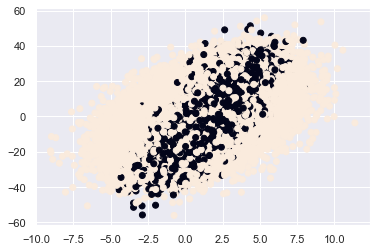

In [8]:
plt.scatter(X_test_big[:, 0], X_test_big[:, 1], c=y_test_big)

ROC-AUC случайного леса с дефолтными параметрами:

In [9]:
clf = GaussianNB()
clf.fit(X, y)
p_test_predict_big = clf.predict_proba(X_test_big)[:, 1]
true_score_estimate = roc_auc_score(y_test_big, p_test_predict_big)
true_score_estimate

0.727490796588157

ROC-кривые для двух классификаторов: идеального и не очень.

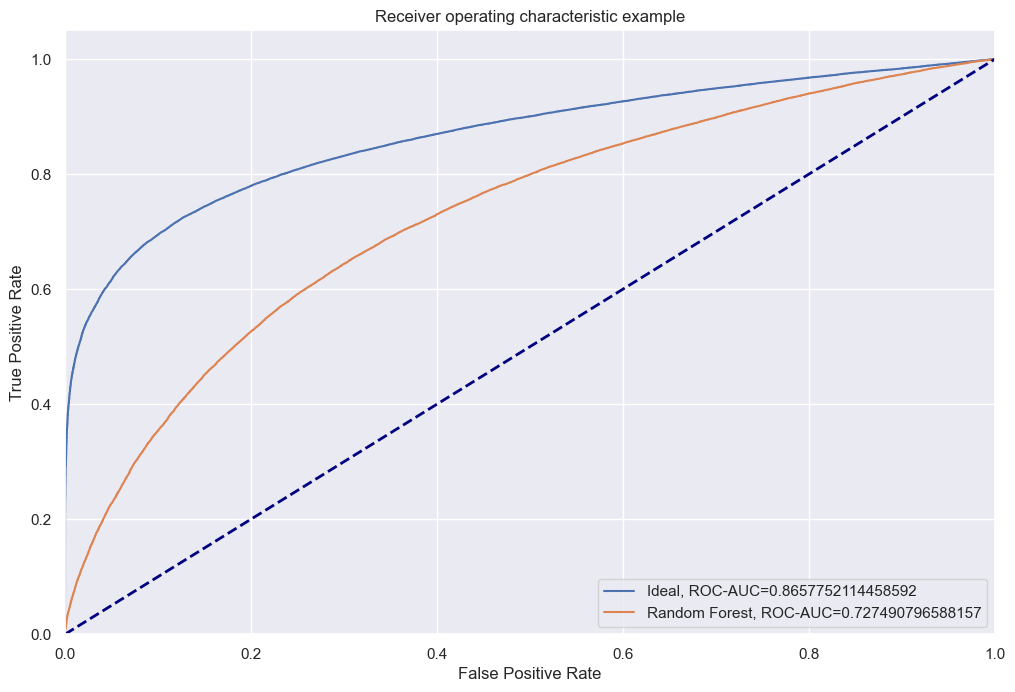

In [10]:
plot_roc_auc([p_test_big, p_test_predict_big], [y_test_big, y_test_big], ['Ideal', 'Random Forest'])

# 2. Metric estimation and confidence intervals

  * QxK CV
  * Leave-one-out CV
  * (tbd in lecture) Vanilla bootstrap
  * (tbd in lecture) out-of-bag bootstrap
  * (tbd in lecture) 0.632-bootstrap
  * (tbd in lecture) $\omega$-bootstrap

### QxK Cross-Validation

In [11]:
def qk_cv(clf, X, y, q=5, k=5, metric=roc_auc_score, random_state=1337):
    metric = make_scorer(metric, needs_proba=False)
    metric_vals = cross_val_score(clf, X, y, 
                                  cv=RepeatedStratifiedKFold(n_splits=k, n_repeats=q, random_state=random_state), 
                                  n_jobs=-1, scoring=metric)
    std = np.std(np.array(metric_vals).reshape(-1, k), axis=1) / np.sqrt(k - 1)
    return metric_vals, std

### Leave-pair-out CV

http://proceedings.mlr.press/v8/airola10a/airola10a.pdf



In [13]:
import itertools
class LeavePairOut:
    def __init__(self, random_state=1337, **kwargs):
        self._random_state = random_state
    
    def get_n_splits(self, X, y, groups=None):
        assert len(X) == len(y)
        n = len(X)
        idx = np.arange(n)
        idx_minus = idx[y == 0]
        idx_plus = idx[y == 1]
        idx = set(idx)
        test_indices = list(itertools.product(idx_minus, idx_plus))
        return len(test_indices)
        
    def split(self, X, y, groups=None):
        assert len(X) == len(y)
        n = len(X)
        idx = np.arange(n)
        idx_minus = idx[y == 0]
        idx_plus = idx[y == 1]
        idx = set(idx)
        test_indices = list(itertools.product(idx_minus, idx_plus))
        for test_index in tqdm(test_indices):
            train_index = np.array(list(idx - set(test_index)))
            yield train_index, np.array(test_index)
            
def lpo_cv(clf, X, y, metric=roc_auc_score):
    metric = make_scorer(metric, needs_proba=False)
    print(LeavePairOut().get_n_splits(X, y))
    metric_vals = cross_val_score(clf, X, y, 
                                  cv=LeavePairOut(), n_jobs=-1, scoring=metric)
    std = np.std(np.array(metric_vals))
    std = np.full(len(metric_vals), std)
    return metric_vals, std

### Считаем валидационные скоры для всех моделей

In [14]:
vals_cv_40_5, std_cv_40_5 = qk_cv(clf, X, y, q=5, k=5)
vals_cv_40_10, std_cv_40_10 = qk_cv(clf, X, y, q=5, k=10)
vals_cv_40_20, std_cv_40_20 = qk_cv(clf, X, y, q=5, k=20)
vals_lpocv, std_lpocv = lpo_cv(clf, X, y)

  0%|          | 623/249951 [00:00<00:40, 6224.72it/s]

249951


100%|██████████| 249951/249951 [00:44<00:00, 5609.89it/s]


In [16]:
cross_vals = [
    vals_cv_40_5, vals_cv_40_10, vals_cv_40_20, vals_lpocv
]

cross_std = [
    std_cv_40_5, std_cv_40_10, std_cv_40_20, std_lpocv
]

labels = [
    "5x5 CV", "5x10 CV", "5x20 CV", "LPO-CV"
]

assert len(cross_vals) == len(cross_std) == len(labels)

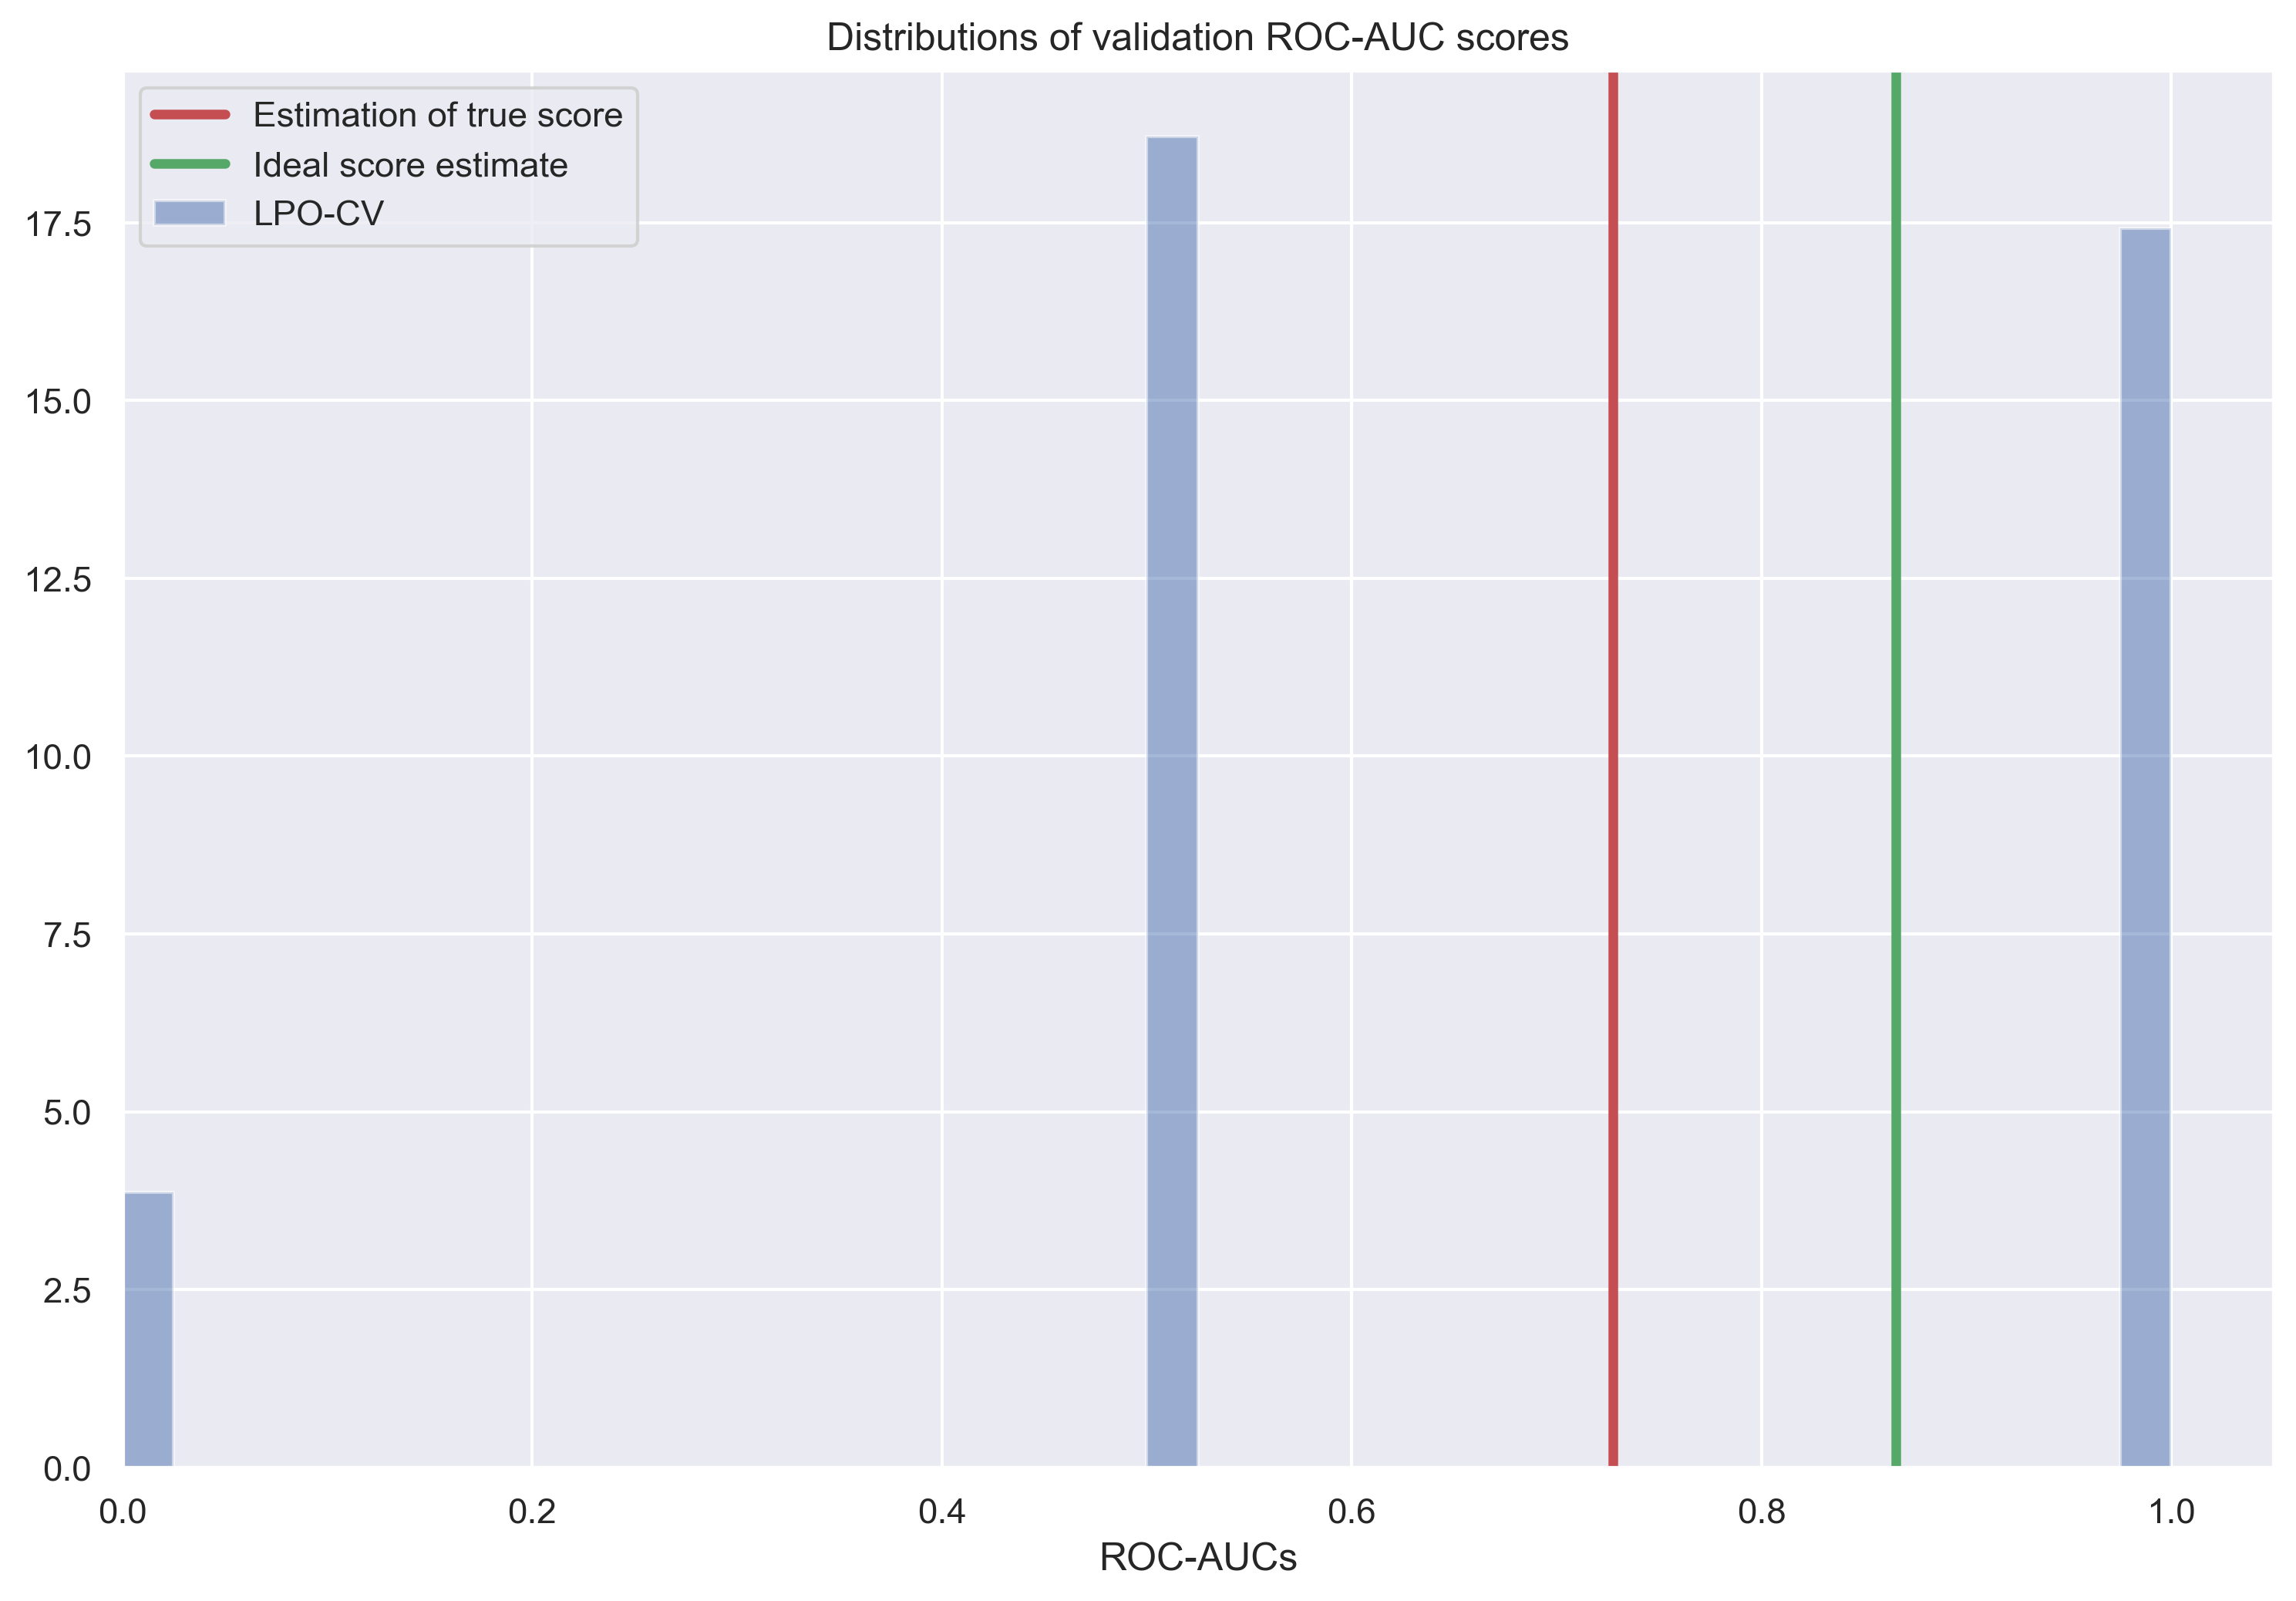

In [24]:
plt.figure(figsize=(12, 8), dpi=300)
plt.title('Distributions of validation ROC-AUC scores')
for vals, label in zip(cross_vals[3:4], labels[3:4]):
    plt.hist(vals, density=True, bins=40, label=label, alpha=0.5, range=(0., 1.))

plt.xlabel('ROC-AUCs')
plt.xlim(0.0, 1.05)
plt.axvline(true_score_estimate, lw=3, c='r', label="Estimation of true score")
plt.axvline(ideal_score_estimate, lw=3, c='g', label="Ideal score estimate")
plt.legend()
plt.show()

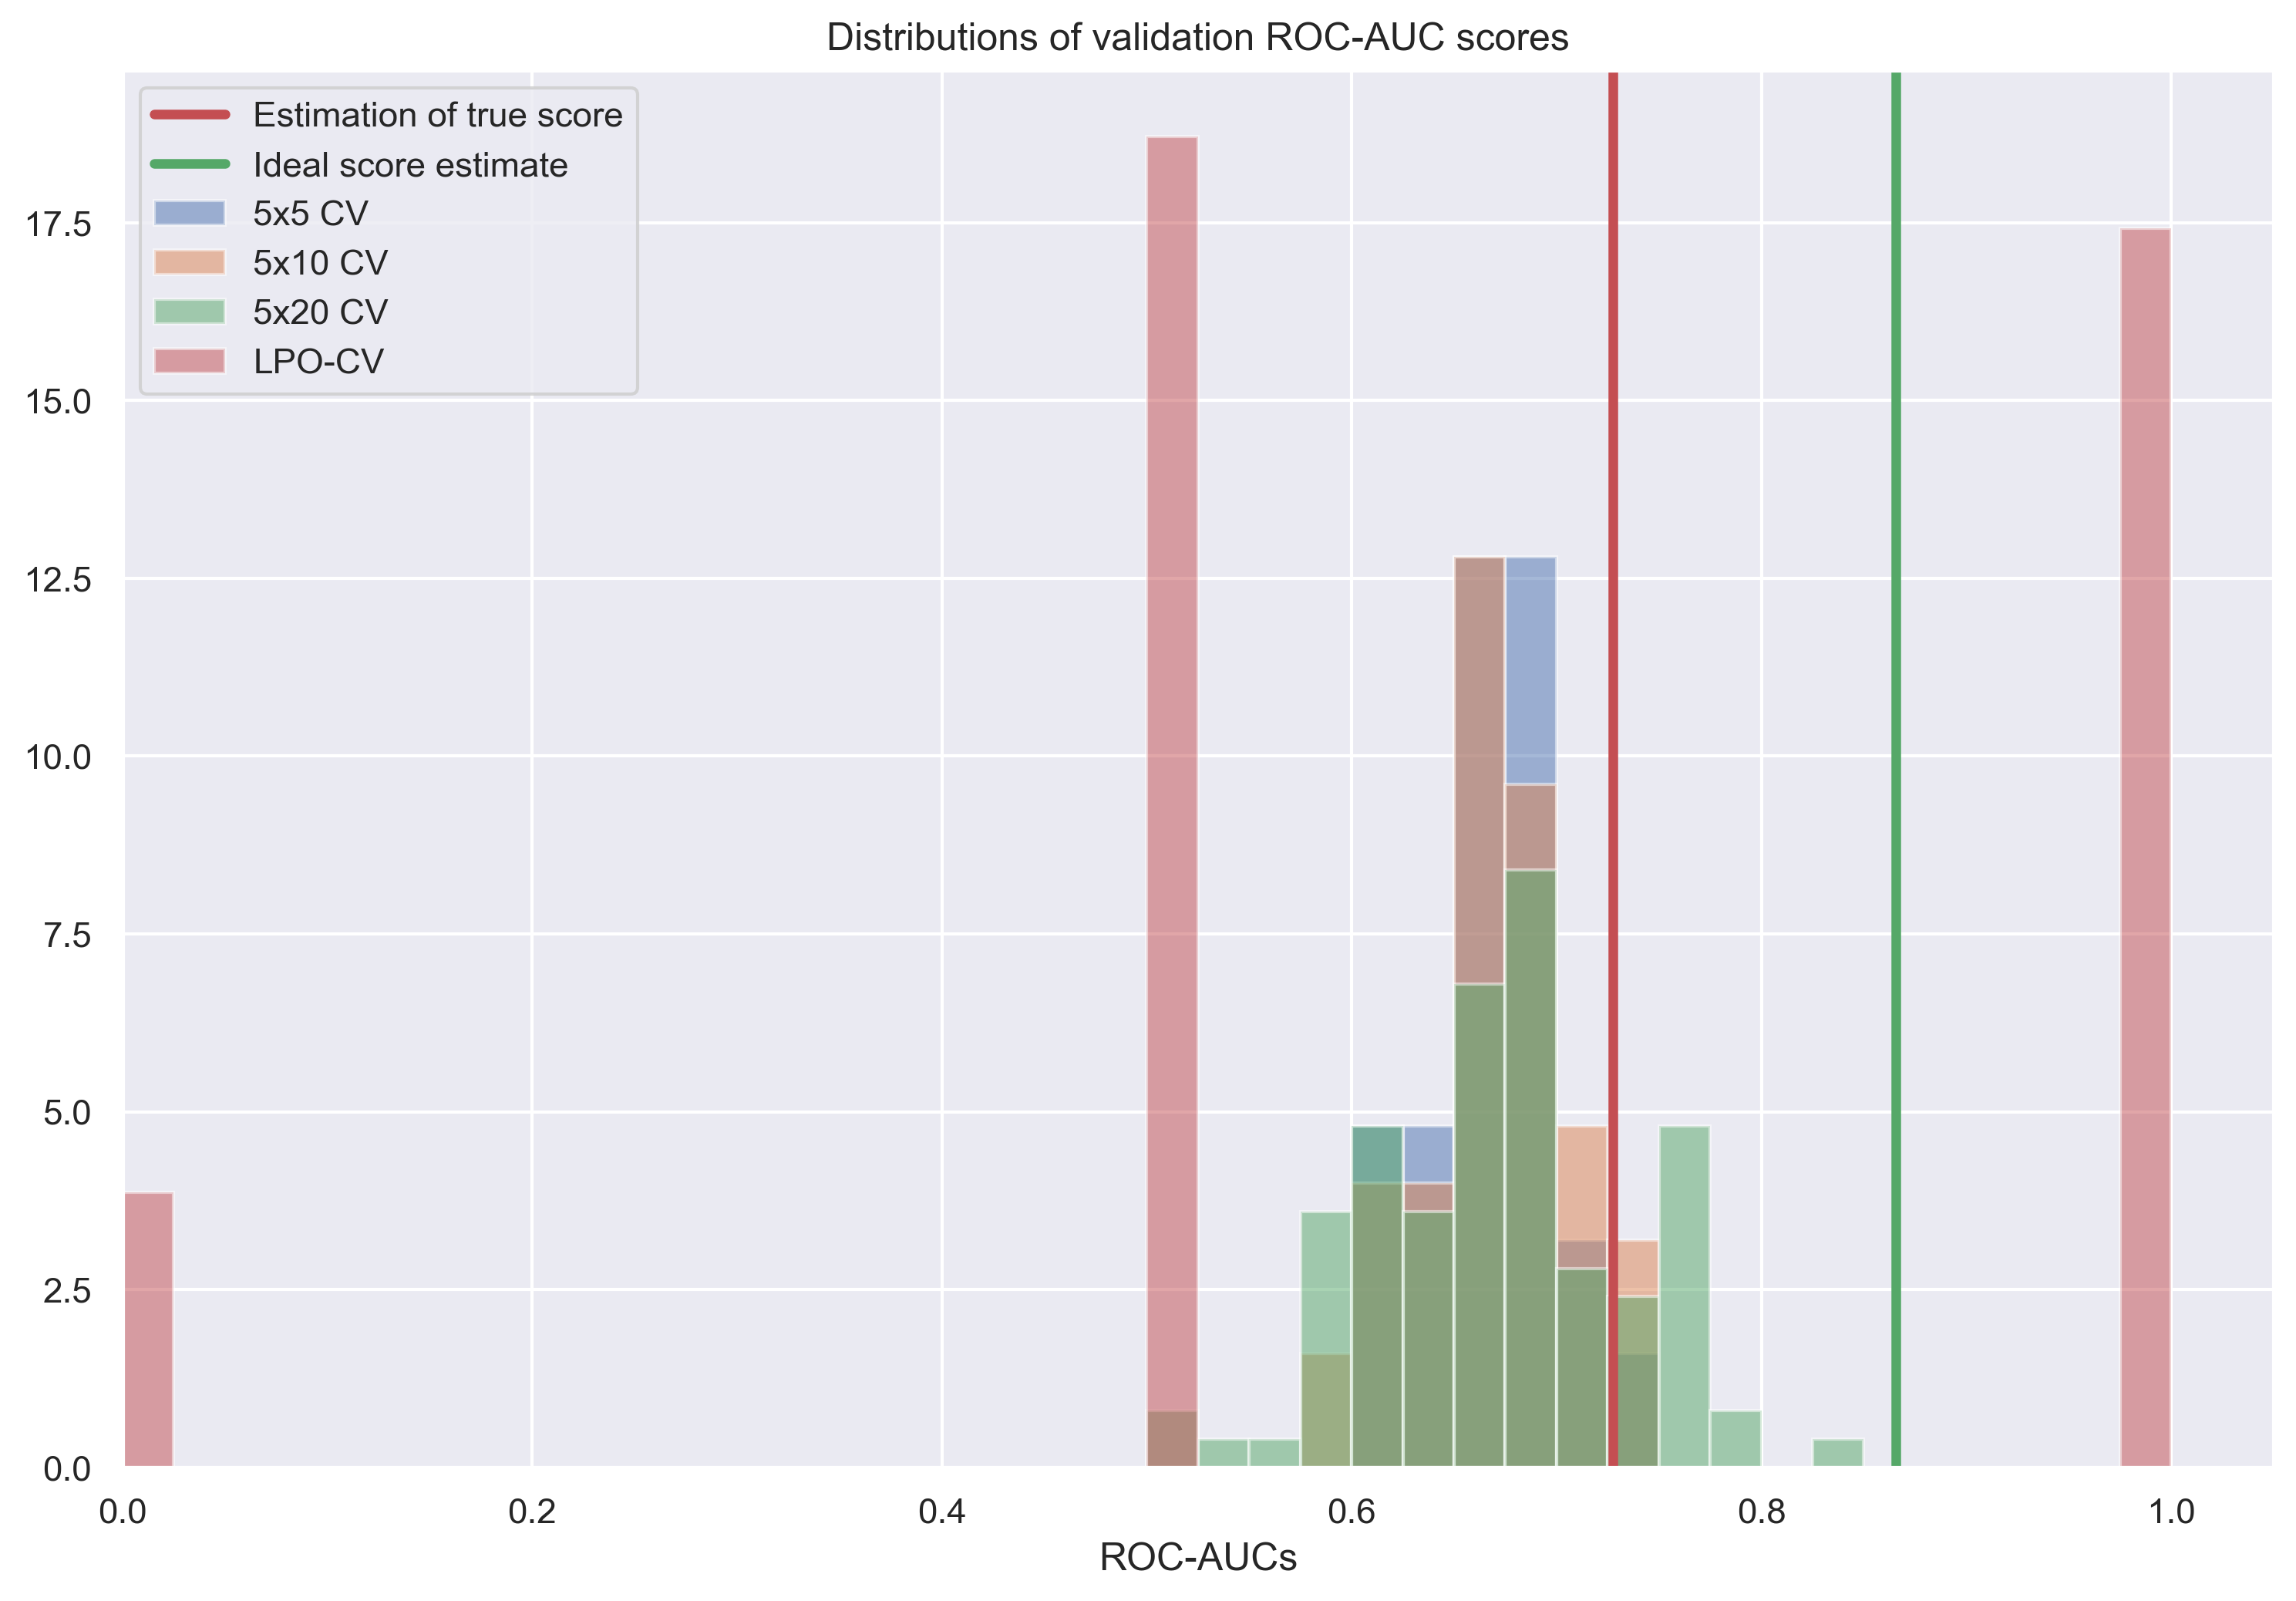

In [22]:
plt.figure(figsize=(12, 8), dpi=300)
plt.title('Distributions of validation ROC-AUC scores')
for vals, label in zip(cross_vals, labels):
    plt.hist(vals, density=True, bins=40, label=label, alpha=0.5, range=(0., 1.))

plt.xlabel('ROC-AUCs')
plt.xlim(0.0, 1.05)
plt.axvline(true_score_estimate, lw=3, c='r', label="Estimation of true score")
plt.axvline(ideal_score_estimate, lw=3, c='g', label="Ideal score estimate")
plt.legend()
plt.show()

## Bias and variance of all methods

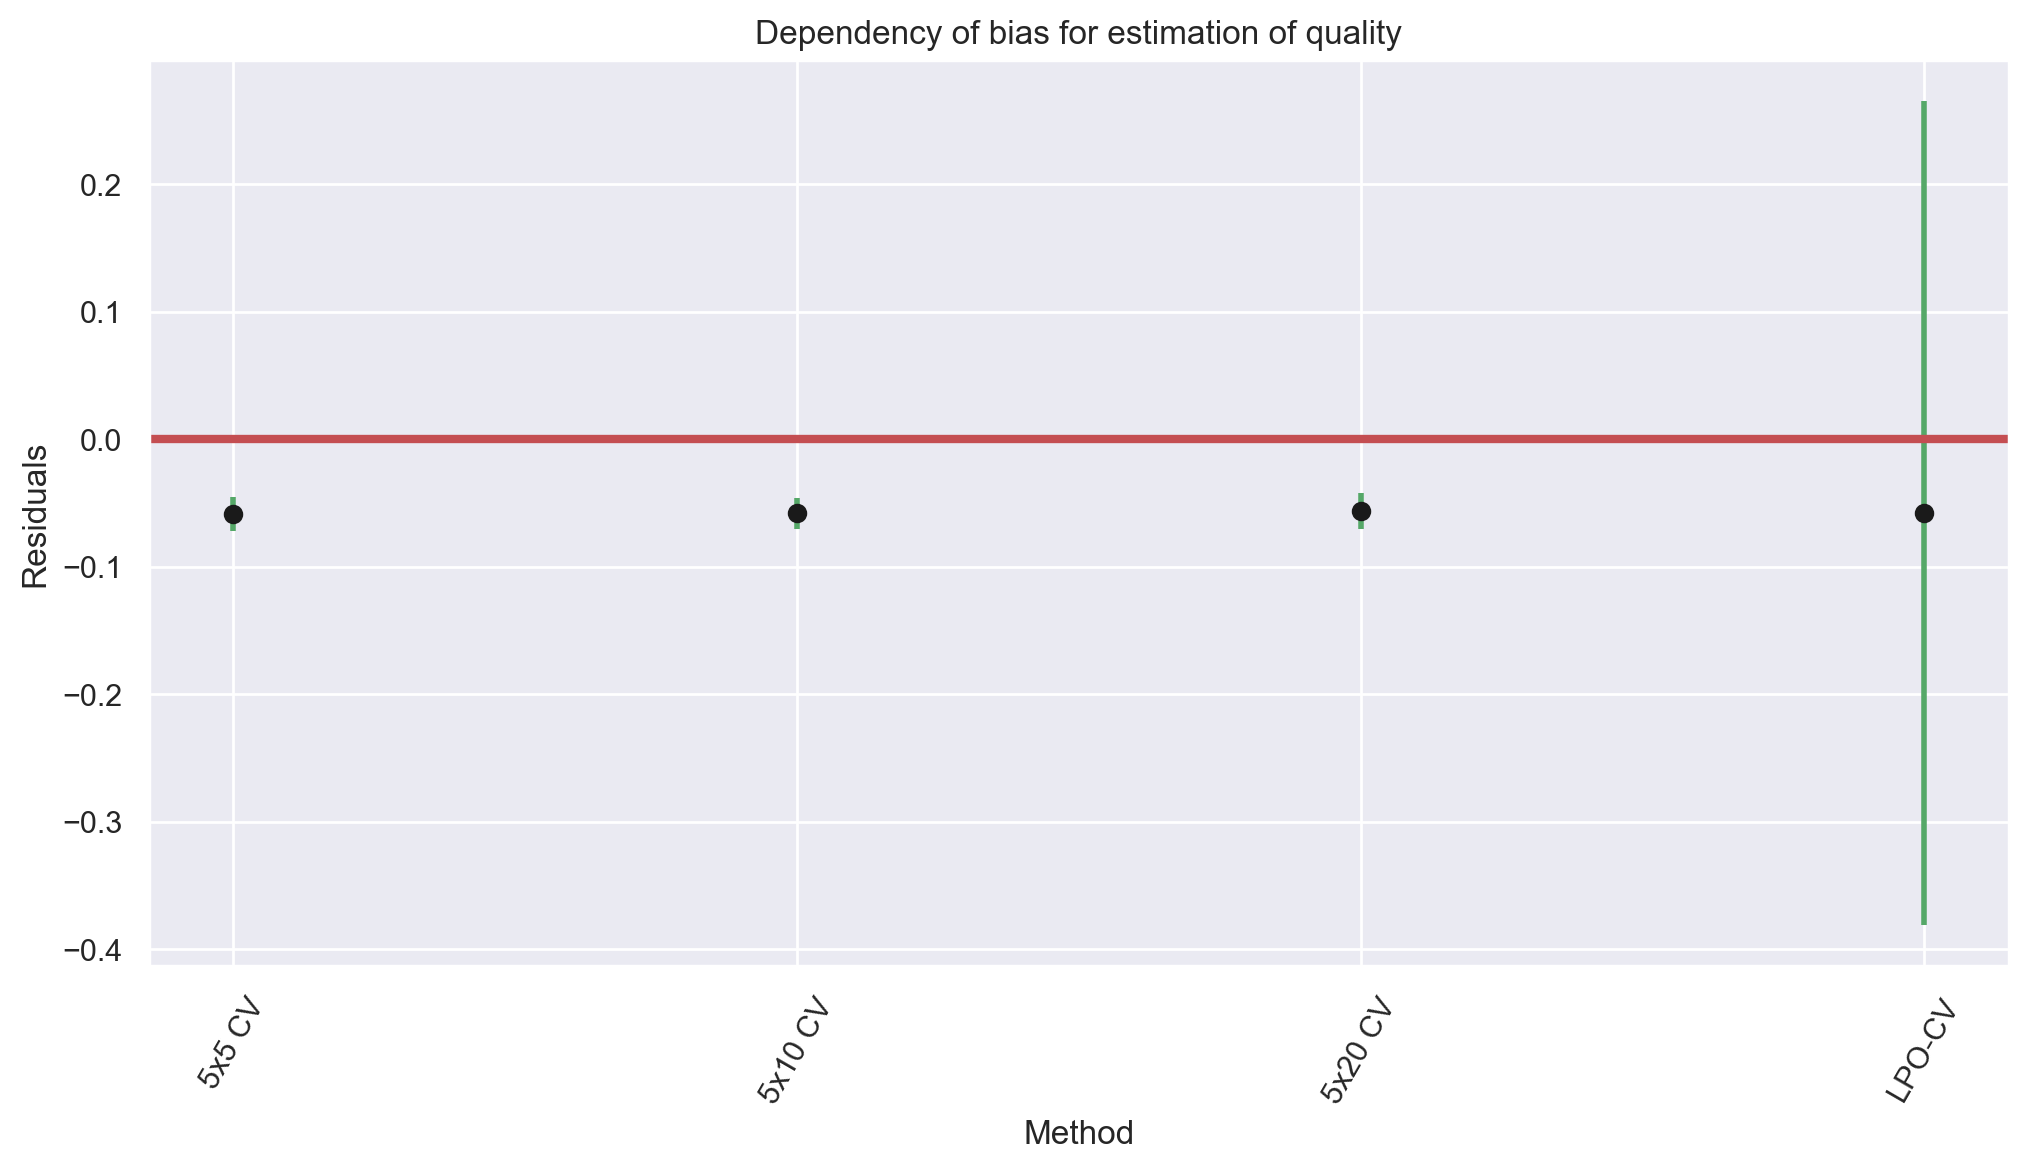

In [29]:
plt.figure(figsize=(12, 6), dpi=200)
plt.title("Dependency of bias for estimation of quality")
plt.axhline(0., lw=3, c='r', label="Estimation of true score")

x = np.arange(len(cross_vals))

plt.errorbar(x, 
             np.array([np.mean(cv) for cv in cross_vals]) - true_score_estimate, 
             [np.mean(std) for std in cross_std], 
             fmt='ok', 
             lw=2, alpha=1., ecolor='g')

plt.xticks(x, labels, rotation=60)
plt.ylabel('Residuals')
plt.xlabel('Method')
plt.show()

### Распределение p-value и ошибка первого рода для `наивного` сравнения двух алгоритмов

In [30]:
algorithm_1 = GaussianNB()
algorithm_2 = GaussianNB()

In [31]:
count = 0
N = 1000
count = 0
z_statistics = []
for i in tqdm(range(N)):
    # делаем кросс-валидацию
    vals_1, stds_1 = qk_cv(algorithm_1, X, y, q=1, k=5, random_state=1337 + i)
    vals_2, stds_2 = qk_cv(algorithm_2, X, y, q=1, k=5, random_state=1338 + i)
    
    # считаем (mean_1 - mean_2) / sqrt(std_1**2 + std_2**2)
    z_statistic = (vals_1 - vals_2).mean() / np.sqrt((stds_1.mean())**2 + (stds_2.mean())**2)
    z_statistics.append(z_statistic)
    
    # считаем ошибку 1-рода
    count += (1 - norm.cdf(np.abs(z_statistic)) < 0.05)

 70%|██████▉   | 696/1000 [00:07<00:03, 94.73it/s] 


KeyboardInterrupt: 

In [ ]:
count / N

In [ ]:
np.sqrt((stds_1.mean())**2 + (stds_2.mean())**2)

In [ ]:
vals_1.mean(), vals_2.mean()

In [ ]:
plt.hist(norm.cdf(z_statistics), bins=100);

# 2. Bias and variance of Cross-Validation

https://www.jmlr.org/papers/volume5/grandvalet04a/grandvalet04a.pdf
   

## 2.1 Посмотрим на матрицу ковариаций ошибок в кросс-валидации

In [32]:
def generate_regression_dataset(size=1000, d=30, p=0.95):
    t = np.random.binomial(n=1, p=p, size=size)
    X = np.random.randn(size, d) * np.sqrt(t * 1 + (1 - t) * 100).reshape(-1, 1)
    y = np.sqrt(3 / (d * (p + 100 * (1 - p)))) * X.sum(axis=1) + np.random.randn(size) * np.sqrt( t * 1 / (p + 100 * (1 - p)) + (1 - t) * 100 / (p + 100 * (1 - p)) )
    return X, y

In [54]:
from sklearn.linear_model import TheilSenRegressor

In [55]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def qk_cv_errors(clf, X, y, q=5, k=5, random_state=1337):
    errors = []
    for i in range(q):
        kf = split(np.arange(len(y)), k)
        for test_index in kf:
            train_index = np.sort(list(set(np.arange(len(y))) - set(test_index)))
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            if hasattr(clf, 'predict_proba'):
                errors.extend(clf.predict_proba(X_test) - y_test)
            else:
                errors.extend(clf.predict(X_test) - y_test)
    return errors

In [59]:
from sklearn.linear_model import LinearRegression, ElasticNet

def generate_errors(n_trials=1000, n_samples=120, k=4, p=1):
    errors = []
    for _ in range(n_trials):
        X, y = generate_regression_dataset(n_samples, p=p)
        errors_ = qk_cv_errors(ElasticNet(), X, y, q=1, k=k)
        # X, y = classification_problem.generate(n_samples)
        # errors_ = qk_cv_errors(GaussianNB(), X, y, q=1, k=k)
        errors.append(errors_)
    errors = np.array(errors).T
    return errors

In [60]:
%%time
n = 120
k = 5
errors = generate_errors(n_trials=30000, n_samples=n, k=k, p=1.) # никаких outliers, CV-5
error_covariance = np.cov(errors)

KeyboardInterrupt: 

In [40]:
errors.shape

(120, 30000)

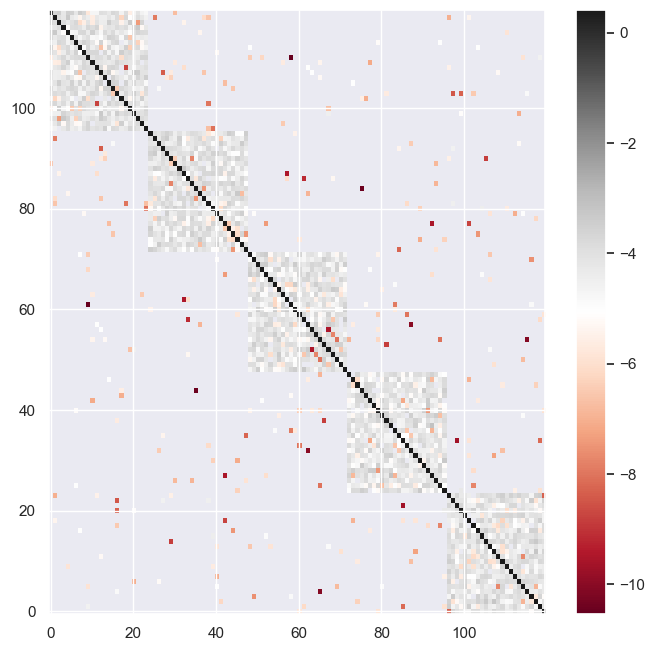

In [41]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(
    np.log(error_covariance[::-1]), 
    origin='lower', 
    aspect='auto',
    cmap='RdGy'
)
plt.colorbar()
plt.show()

## 2.2 На что раскладывается истинная ошибка?

$$Var(\hat\mu) = \frac{1}{n} \sigma^2 + \frac{m - 1}{n} \omega + \frac{n - m}{n} \gamma,$$

где $\hat\mu$ это некоторая величина оцениваемая с помощью кросс-валидации.

In [42]:
def estimate_covs(error_covariance, k=4):
    n = len(error_covariance)
    m = n // k
    sigma = []
    omega = []
    gamma = []
    for i in range(len(error_covariance)):
        for j in range(len(error_covariance)):
            if i == j:
                sigma.append(error_covariance[i, j])
            elif i // m == j // m:
                omega.append(error_covariance[i, j])
            else:
                gamma.append(error_covariance[i, j])
    return np.array(sigma),  np.array(omega),  np.array(gamma)

In [43]:
sigma, omega, gamma = estimate_covs(error_covariance=error_covariance)

In [44]:
error_covariance.mean()

0.001655347113520595

In [45]:
np.mean(sigma) / n, np.mean(omega) * (n // k + 1) / n, np.mean(gamma) * (n - n // k) / n

(0.012373833825021625, 0.00046246598921726925, -0.012005277076259264)

In [46]:
n / k

24.0

In [47]:
np.mean(sigma) / n + np.mean(omega) * (n // k + 1) / n + np.mean(gamma) * (n - n // k) / n

0.0008310227379796295

In [48]:
(np.std(errors, axis=0)**2).mean() / n

0.012359929588248282

In [49]:
len(sigma) + len(omega) + len(gamma)

14400

In [50]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("Distribution or errors")
plt.hist(np.std(errors, axis=0)**2, bins=20);
plt.axvline(error_covariance.mean() * n, c='r', label=r"$\theta$");
plt.axvline(np.diag(error_covariance).mean(), c='g', label=r"$\sigma^2$");
plt.legend()
plt.show()

## 2.2 Разложение ошибки в зависимости от размера выборки, количества фолдов и наличия аутлаеров

In [61]:
from collections import defaultdict

statistics = defaultdict(lambda: defaultdict(list))
ps = [0.95, 1]
ks = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 30, 40, 60]
ns = [60, 80, 100, 120, 160, 220, 280, 360, 460, 600]

for p in ps:
    n = 120
    for k in tqdm(ks):
        errors = generate_errors(n_trials=100, n_samples=n, k=k, p=p)
        error_covariance = np.cov(errors)
        sigma, omega, gamma = estimate_covs(error_covariance=error_covariance)
        statistics[(p, k, n)]["sigma"] = sigma
        statistics[(p, k, n)]["omega"] = omega
        statistics[(p, k, n)]["gamma"] = gamma
    
    k = 10
    for n in tqdm(ns):
        errors = generate_errors(n_trials=100, n_samples=n, k=k, p=p)
        error_covariance = np.cov(errors)
        sigma, omega, gamma = estimate_covs(error_covariance=error_covariance)
        statistics[(p, k, n)]["sigma"] = sigma
        statistics[(p, k, n)]["omega"] = omega
        statistics[(p, k, n)]["gamma"] = gamma

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


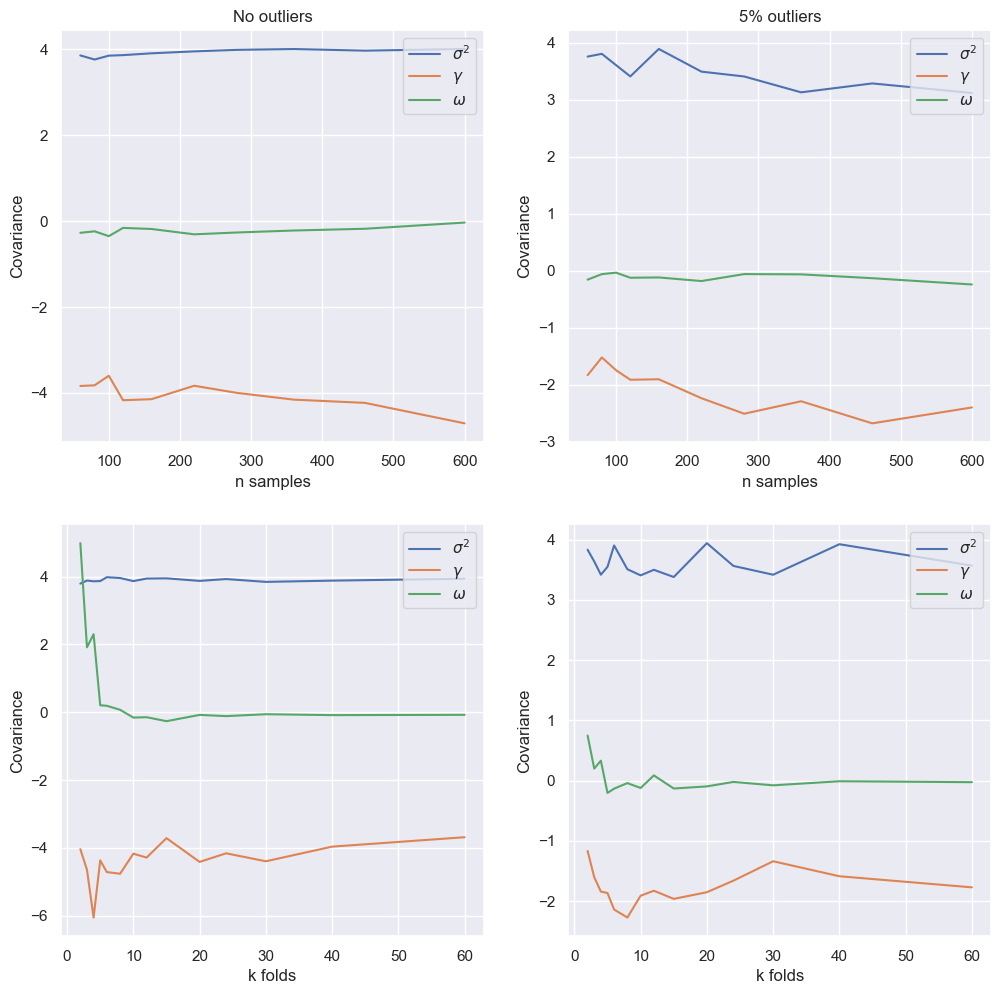

In [62]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=100, nrows=2, ncols=2)

p = 1
k = 10
ax[0][0].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for n in ns], 
    label=r'$\sigma^2$'
)
ax[0][0].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for n in ns], 
    label=r'$\gamma$'
)
ax[0][0].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for n in ns], 
    label=r'$\omega$'
)
ax[0][0].set_ylabel("Covariance")
ax[0][0].set_xlabel("n samples")
ax[0][0].set_title('No outliers')

p = 0.95
k = 10
ax[0][1].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for n in ns], 
    label=r'$\sigma^2$'
)
ax[0][1].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for n in ns], 
    label=r'$\gamma$'
)
ax[0][1].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for n in ns], 
    label=r'$\omega$'
)
ax[0][1].set_ylabel("Covariance")
ax[0][1].set_xlabel("n samples")
ax[0][1].set_title('5% outliers')

p = 1
n = 120
ax[1][0].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for k in ks], 
    label=r'$\sigma^2$'
)
ax[1][0].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for k in ks], 
    label=r'$\gamma$'
)
ax[1][0].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for k in ks], 
    label=r'$\omega$'
)
ax[1][0].set_ylabel("Covariance")
ax[1][0].set_xlabel("k folds")

p = 0.95
n = 120
ax[1][1].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for k in ks], 
    label=r'$\sigma^2$'
)
ax[1][1].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for k in ks], 
    label=r'$\gamma$'
)
ax[1][1].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for k in ks], 
    label=r'$\omega$'
)
ax[1][1].set_ylabel("Covariance")
ax[1][1].set_xlabel("k folds")
for axx in ax:
    for axxx in axx:
        axxx.legend(loc="upper right")
plt.show()

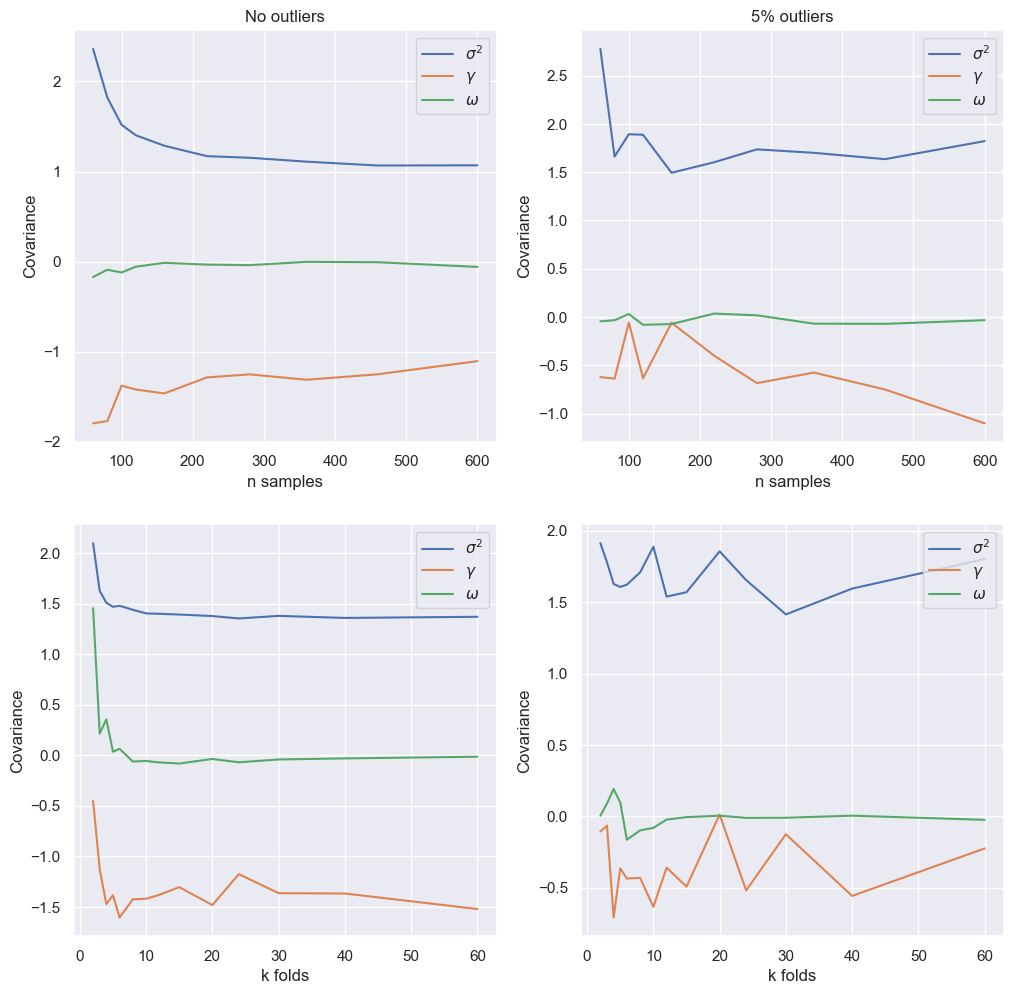

In [53]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=100, nrows=2, ncols=2)

p = 1
k = 10
ax[0][0].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for n in ns], 
    label=r'$\sigma^2$'
)
ax[0][0].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for n in ns], 
    label=r'$\gamma$'
)
ax[0][0].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for n in ns], 
    label=r'$\omega$'
)
ax[0][0].set_ylabel("Covariance")
ax[0][0].set_xlabel("n samples")
ax[0][0].set_title('No outliers')

p = 0.95
k = 10
ax[0][1].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for n in ns], 
    label=r'$\sigma^2$'
)
ax[0][1].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for n in ns], 
    label=r'$\gamma$'
)
ax[0][1].plot(
    ns, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for n in ns], 
    label=r'$\omega$'
)
ax[0][1].set_ylabel("Covariance")
ax[0][1].set_xlabel("n samples")
ax[0][1].set_title('5% outliers')

p = 1
n = 120
ax[1][0].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for k in ks], 
    label=r'$\sigma^2$'
)
ax[1][0].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for k in ks], 
    label=r'$\gamma$'
)
ax[1][0].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for k in ks], 
    label=r'$\omega$'
)
ax[1][0].set_ylabel("Covariance")
ax[1][0].set_xlabel("k folds")

p = 0.95
n = 120
ax[1][1].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["sigma"]) for k in ks], 
    label=r'$\sigma^2$'
)
ax[1][1].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["gamma"]) * (n - n // k) for k in ks], 
    label=r'$\gamma$'
)
ax[1][1].plot(
    ks, 
    [np.mean(statistics[(p, k, n)]["omega"]) * (n // k) for k in ks], 
    label=r'$\omega$'
)
ax[1][1].set_ylabel("Covariance")
ax[1][1].set_xlabel("k folds")
for axx in ax:
    for axxx in axx:
        axxx.legend(loc="upper right")
plt.show()

## 2.4 Как оценивать дисперсию?

### 1. Самый наивный вариант: нет никаких корреляций

$$\hat\theta_4 = \frac{1}{n} \frac{1}{n - 1} \sum (e_i - \hat\mu)^2$$

Главная проблема: слишком наивный.

### 2. Менее наивный вариант: $\omega$ и $\gamma$ линейно связаны

$$\hat\theta_3 = \frac{1}{n} \frac{1}{K} \sum \frac{1}{m - 1} \sum (e_i - \hat\mu_K)^2$$

Главная проблема: предполагается что $\hat\mu$ и $\hat\mu_K$ ортогональные или что $\omega$ и $\gamma$ достаточно малы чтобы можно их было линеаризовать. 

Иногда работает.

### 3. Нет корреляций между тестовыми сэмплами: $\gamma = 0$

$$\hat\theta_2 = \frac{1}{K} \frac{1}{K - 1} \sum (\hat\mu - \hat\mu_K)^2$$

Главная проблема: ломается если (1) в датасете есть аутлаеры, (2) алгоритм оверфитится на сэмлп.

Но, в целом, достаточно стабильный метод.

### 4. Нет корреляций внутри тестового сэмпла:  $\omega = 0$

$$\hat\theta_1 = \frac{1}{n} \frac{1}{m - 1} \sum \left( (e_i - \hat\mu)^2 + \sum\sum(e_i - \hat\mu) (e_j - \hat\mu) \right)$$

Главная проблема: оценка аналогична truncated sample covariance и в некоторых случаях может быть отрицательной.

## 2.4 Воспользуемся методом (3), но попытаемся учесть что $\gamma \neq 0$

http://www-labs.iro.umontreal.ca/~lisa/pointeurs/xv_rho_stat_tr1285.pdf

Предположение: $\hat\mu_k$ -- нормальные случайные величины, $\rho = \frac{\gamma}{\theta}$, то:

$$t_{K-1} = \sqrt{K(K - 1)(1 - \rho)} \frac{\hat\mu - \mu}{\sqrt{\sum (\hat\mu - \hat\mu_k)^2}} \sim t-\textrm{distribution}(\nu=K-1)$$

In [63]:
def k_cv_rho(clf1, clf2, X, y, k=5, rho=0.7, metric=roc_auc_score, random_state=1337):
    metric = make_scorer(metric, needs_proba=False)
    hat_mu_k_1 = cross_val_score(
        clf1, X, y, 
        cv=RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=random_state),
        n_jobs=-1, scoring=metric
    )
    hat_mu_k_2 = cross_val_score(
        clf2, X, y, 
        cv=RepeatedStratifiedKFold(n_splits=k, n_repeats=1, random_state=random_state),
        n_jobs=-1, scoring=metric
    )
    hat_mu_k = hat_mu_k_1 - hat_mu_k_2
    hat_mu = hat_mu_k.mean()
    t = np.sqrt(k * (k - 1) * (1 - rho)) * hat_mu / np.sqrt(((hat_mu - hat_mu_k)**2).sum())
    return hat_mu_k, t

In [64]:
X, y = classification_problem.generate(samples=100)

In [65]:
_, t_hat = k_cv_rho(ExtraTreesClassifier(n_estimators=5), ExtraTreesClassifier(n_estimators=5), X, y, k=5)

In [68]:
N = 100
rhos = np.linspace(0, 0.7, 10)
p_values = []
target_p_value = 0.05

for rho in tqdm(rhos):
    p_value = 0
    for _ in range(N):
        idx = np.random.randint(low=0, high=len(X), size=len(X))
        X_b, y_b = X[idx], y[idx]
        _, t_hat = k_cv_rho(
            ExtraTreesClassifier(n_estimators=5), ExtraTreesClassifier(n_estimators=5), X_b, y_b, 
            k=5, rho=rho
        )
        if (1 - stats.t.cdf(np.abs(t_hat), df=5 - 1)) < 0.05:
            p_value += 1 / N
    p_values.append(p_value)

100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


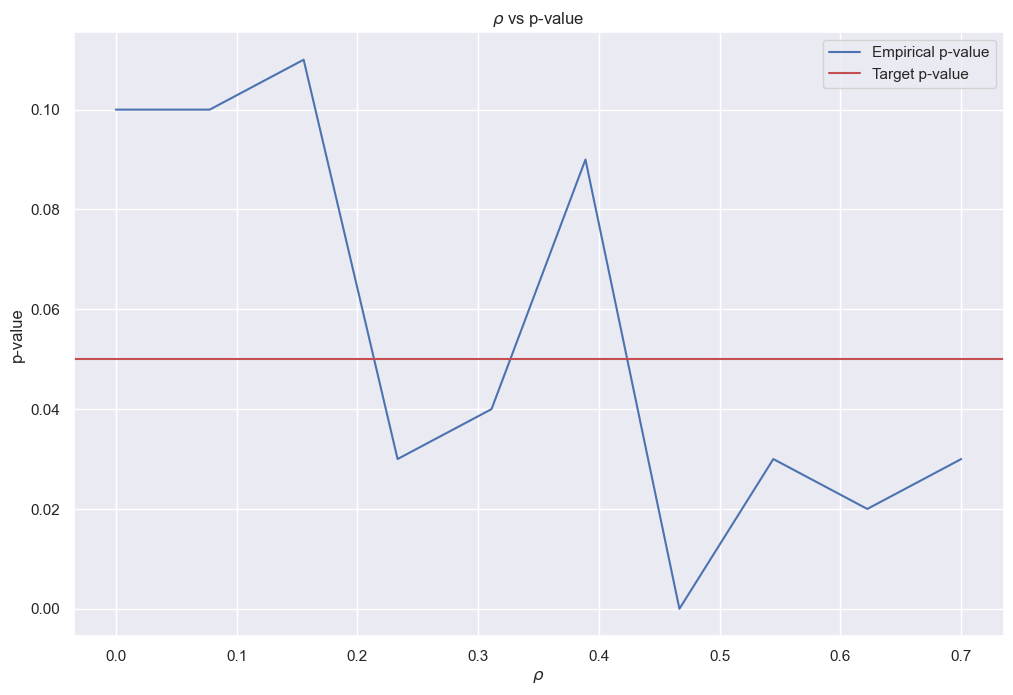

In [69]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title(r"$\rho$ vs p-value")
plt.xlabel(r'$\rho$')
plt.ylabel('p-value')
plt.plot(rhos, p_values, label="Empirical p-value")
plt.axhline(0.05, c='r', label='Target p-value')
plt.legend()
plt.show()

# 3. Algorithm comparison

  * DeLong test
  * rho-CV paired t-test
  * (tbd in lecture) Dietterich's 5x2-Fold CV paired t-test
  * (tbd in lecture) Alpaydin’s Combined 5x2 CV F-test

In [ ]:
algorithm_1 = ExtraTreesClassifier(10)
algorithm_2 = ExtraTreesClassifier(10)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
algorithm_1.fit(X_train, y_train);
algorithm_2.fit(X_train, y_train);

In [ ]:
y_proba_1 = algorithm_1.predict_proba(X_test)[:, 1]
y_proba_2 = algorithm_2.predict_proba(X_test)[:, 1]

In [ ]:
roc_auc_score(y_test, y_proba_1), roc_auc_score(y_test, y_proba_2)

### DeLong test


In [ ]:
from compare_auc_delong_xu import delong_roc_variance

In [ ]:
delong_mean_1, delong_var_1 = delong_roc_variance(y_test, y_proba_1)
delong_mean_2, delong_var_2 = delong_roc_variance(y_test, y_proba_2)

In [ ]:
z_statistic = np.abs(delong_mean_1 - delong_mean_2) / np.sqrt(delong_var_1**2 + delong_var_2**2)

In [ ]:
1 - norm.cdf(np.abs(z_statistic))

#### Расчёт ошибки 1 рода

In [ ]:
N = 1000
count = 0
z_statistics = []

for _ in tqdm(range(N)):
    X, y = classification_problem.generate(samples=100)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    y_proba_1 = ExtraTreesClassifier(10).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    y_proba_2 = ExtraTreesClassifier(10).fit(X_train, y_train).predict_proba(X_test)[:, 1]
    delong_mean_1, delong_var_1 = delong_roc_variance(y_test, y_proba_1)
    delong_mean_2, delong_var_2 = delong_roc_variance(y_test, y_proba_2)
    roc_auc_1, roc_auc_2 = roc_auc_score(y_test, y_proba_1), roc_auc_score(y_test, y_proba_2)
    z_statistic = (roc_auc_1 - roc_auc_2) / np.sqrt(delong_var_1 + delong_var_2)
    z_statistics.append(z_statistic)
    count += ((1 - norm.cdf(np.abs(z_statistic))) < 0.05)
print(count / N)

In [ ]:
plt.hist(norm.cdf(z_statistics));

### k-fold CV paired t-test

In [ ]:
_, t_statistic = k_cv_rho(ExtraTreesClassifier(10), ExtraTreesClassifier(10), X, y, k=5)

In [ ]:
1 - stats.t.cdf(np.abs(t_statistic), df=k - 1)

#### Расчёт ошибки 1 рода

In [ ]:
k = 5
N = 100
count = 0
for _ in tqdm(range(N)):
    X, y = classification_problem.generate(samples=100)
    _, t_statistic = k_cv_rho(ExtraTreesClassifier(10), ExtraTreesClassifier(10), X, y, k=k, rho=0.3)
    count += (1 - stats.t.cdf(np.abs(t_statistic), df=k - 1)) < 0.05
print(count / N)

## Этот раздел мы обсуждать не будет, так как на лекциях этого материала ещё не было

## Stay tuned...

### Dietterich's 5x2-Fold CV paired t-test

In [ ]:
xx, _ = qk_cv(algorithm_1, X, y, q=5, k=2, random_state=1337)
yy, _ = qk_cv(algorithm_2, X, y, q=5, k=2, random_state=1337)

In [ ]:
roc_auc_A = (xx - yy)[::2]
roc_auc_B = (xx - yy)[1::2]
average = (roc_auc_A + roc_auc_B) / 2

In [ ]:
s2 = ((average - roc_auc_A)**2 + (average - roc_auc_B)**2)

In [ ]:
t_statistic = xx[0] / np.sqrt(s2.mean())

In [ ]:
1 - stats.t.cdf(np.abs(t_statistic), df=5)

In [ ]:
k=5
N = 100
count = 0
for _ in tqdm(range(N)):
    xx, _ = qk_cv(ExtraTreesClassifier(), X, y, q=5, k=2, random_state=1337)
    yy, _ = qk_cv(ExtraTreesClassifier(), X, y, q=5, k=2, random_state=1337)
    roc_auc_A = (xx - yy)[::2]
    roc_auc_B = (xx - yy)[1::2]
    average = (roc_auc_A + roc_auc_B) / 2
    s2 = ((average - roc_auc_A)**2 + (average - roc_auc_B)**2)
    t_statistic = xx[0] / np.sqrt(s2.mean())
    count += (1 - stats.t.cdf(np.abs(t_statistic), df=5)) < 0.05
print(count / N)

### Alpaydin’s Combined 5x2 CV F-test

In [ ]:
f_statistic = ((xx**2).sum() + (yy**2).sum()) / (2 * s2.sum())

In [ ]:
1 - f.cdf(np.abs(f_statistic), dfn=10, dfd=5)

In [ ]:
k=5
N = 100
count = 0
for _ in tqdm(range(N)):
    xx, _ = qk_cv(ExtraTreesClassifier(), X, y, q=2, k=k, random_state=1337)
    yy, _ = qk_cv(ExtraTreesClassifier(), X, y, q=2, k=k, random_state=1337)
    roc_auc_A = (xx - yy)[::2]
    roc_auc_B = (xx - yy)[1::2]
    average = (roc_auc_A + roc_auc_B) / 2
    s2 = ((average - roc_auc_A)**2 + (average - roc_auc_B)**2)
    f_statistic = ((xx**2).sum() + (yy**2).sum()) / (2 * s2.sum())
    count += (1 - f.cdf(np.abs(f_statistic), dfn=10, dfd=5)) < 0.05
print(count / N)